# Text Classification with BERT in TensorFlow and PyTorch

The Large Language Models (LLM) like BERT (published in 2018 [1]) have been a huge progress in the development of Natural Language Processing (NLP). LLM help solving many NLP tasks with state-of-the-art performance.
In this article we will show with a practical example how text classification can be performed using BERT, in the two main frameworks used for Deep Learning: TensorFlow and PyTorch. For the BERT part we will use the HuggingFace libraries.
In the first part of this article, we will remind (briefly) what is a Large Language Model, how we can use it for Transfer Learning, and how it can be fine-tuned for a specific task like Classification. Then we will prepare the dataset, develop the models and train them in both TensorFlow and PyTorch frameworks. Finally we will compare the two frameworks.
We have already published an article to show various methods of Text Classification (https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3). In the present article, we re-use a part of what we have written at that time, so there will be some overlapping.

# Text Classification with BERT

The publication of the model BERT in 2018 [1] was a revolution in the NLP world, since Large Language Models like BERT achieve state-of-the-art performance in many NLP tasks. To show how BERT can be used in practice, we develop an example of Text Classification. In these cases, we say that BERT, which contains linguistic capabilities and world knowledge from its numerous sources it was trained with (Wikipedia, books, ...), is used for Transfer Learning, while the Classification exercise we perform is called Fine-Tuning.

"Fine-Tuning" does not mean that we adjust the BERT model. We use BERT as it is,and add a "head" on top of BERT. BERT is used to "encode" some properties of a text into a vector (or tensor). The Classification exercise consists then of a Classification of these vectors. The Classification of these encoded values into vectors becomes a classical classification Machine Learning problem, which can be done either with a classical approach (Logistic Regression, Naive Bayes, ...) or with a Neural Network.

To be more precise, we will not work with BERT directly, but with DistilBERT, which is a simplified model (having only half of BERT's parameters) which mimicks the behaviour of BERT. DistilBERT's performance is very close to BERT's performance (and sometimes even better), despite having only half of the parameters! For more details about this approach you can read [2]. In the present article, we will use the word BERT most of the time, even if we use DistilBERT.

To build a Text Classification model using BERT we can apply two (slightly) different strategies. As mentioned above, BERT is used to encode texts into a vector. The classification model we built on BERT consists of classifying these vectors using ML algorithms. So we can either:
- Apply BERT to the texts as a pre-processing steps, then build a ML model that classifies these vectors
- Build a model which starts with BERT (where we freeze the parameters when training the model), then build on top of BERT a layer that classifies these vectors

The advantage of the first method is that we need to pass the text (training and test data) only once through BERT, and not for each epoch at training, reducing significantly the training time. The advantage of the second method is that we do not need to build an additional step to the pipeline, since the end-to-end (from text to classification) is provided by the tokenizer (see below in the developments what this is) and the model itself.

For pedagogical purpose, we will go with the second approach. In a real case, the choice of the approach would depend on the use of the model. If we need to regularly train the model I would favor the first approach. If the model has to be trained only once I would go for the second approach.

We will use the DistilBERT model from the Python library transformers, which is provided by the company Hugging Face.

# Dataset

In this article we will consider a small dataset: BBC news, classified by topic: https://www.kaggle.com/sainijagjit/bbc-dataset. This corpus contains around 2k entries, which is small enough to be run on a standard computer.

In [2]:
# Libraries needed for data preparation
import pandas as pd
import numpy as np

# Download the dataset and put it in subfolder called data
datapath = "data/bbc-text.csv"
df = pd.read_csv(datapath)
df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Let's analyse the data before doing any Text Classification:

In [1]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

NameError: name 'df' is not defined

We get a total number of entries of 2'225, which are relatively evenly split across five categories. This allows us to apply standard methods, as there is no need to over- or under-weight some categories.

Finally, let's look at a specific example to get a concrete impression:

In [4]:
# You can adjust n:
n=100
print('Category: ',df['category'][n])
print(100*'-')
print('Text:')
print(df['text'][n])

Category:  entertainment
----------------------------------------------------------------------------------------------------
Text:
housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-chann

For Large Language Models (LLM), there is no need to further manually process the data, since tokenizers, i.e. the layers that encode text into "numbers" comes with the model.

The label has to be converted to a number, an "index". Let's do that.

In [5]:
# Renaming, Input -> X, Output -> y
X = df['text']
y=np.unique(df['category'], return_inverse=True)[1]
print(y)

[4 0 3 ... 1 2 3]


Let's also instantiate the BERT tokenizer that will be used later. The same tokenizer can be used for both frameworks TensorFlow and PyTorch.

In [6]:
# distilBERT tokenizer
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/workspace/gomtm/mtmai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


From now we will distinguish between  TensorFlow and PyTorch. The principles are still the same, however the nature of the objects will change. TensorFlow and PyTorch both have their own tensor objects.

# Building a Text Classification in TensorFlow

## Prepare the Dataset

Let's note that TensorFlow has its own Tensors (TensorFlow tensors), and its own dataset types. But the TensorFlow framework can also be used with NumPy arrays, which is in my view simpler to use. This is what we are going to use in the present example. It is a significant difference with PyTorch, where we are almost forced to use PyTorch tensors, PyTorch datasets, and PyTorch dataloader.

We will first convert the input data (the text) into NumPy arrays, using DistilBERT's tokenizer.

We will also split the dataset into a train and a test dataset. When doing this we take care of keeping the same proportions by category between the training and the test datasets.

In [6]:
import tensorflow as tf
X_tf = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in X]
X_tf = np.array(X_tf, dtype='int32')

In [7]:
# Train/test split
from sklearn.model_selection import train_test_split
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y, test_size=0.3, random_state=42, stratify=y)
print('Shape of training data: ',X_tf_train.shape)
print('Shape of test data: ',X_tf_test.shape)

Shape of training data:  (1557, 512)
Shape of test data:  (668, 512)


## Build the Model

Let's build the model. For this we first need to get the BERT layer from the transformer library. We configure it such that its parameters will not be trained during training.

In [8]:
# Get BERT layer
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


You might get a warning message. Don't worry about it. In the context where we apply the model, this message can be ignored.

Let's try to better understand this model by having a closer look at its output. For this, let's take a sample from our training dataset (we take a sample of size five) and look at the output through the model.

In [9]:
# Let's create a sample of size 5 from the training data
sample = X_tf_train[0:5]
print('Object type: ', type(dbert_tf(sample)))
print('Output format (shape): ',dbert_tf(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_tf(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (5, 512, 768)
Output used as input for the classifier (shape):  (5, 768)


The output is a specific Python object. Among other information, we get a Tensor of size (N, M, S), where N is the size of the dataset (in our case five examples), M is the length of the sample (number of words in the text), and S is the size of the output vector (the output of the model). Typically, as mentioned by Devlin et al. [1] for a classification task, we use the first output vector of a sentence as input for the rest of the classification model, since this first vector "encodes" information about the overall text. Alternatively a pooling average of all output vectors could also be used as input for the classifier.

It is now time to build the classification model! It will consist of:
- Input layer: to tell the model which input format to expect, so that the model knows what to expect. This is specific to TensorFlow
- Distil Bert model: to encode the input data into a new sequence of vectors (that is the output of BERT). Only the first vector of this sequence will be used as an input for the rest of the classifier
- Dropout layer: for regularization
- Dense layer (with relu activation function, with 64 neurons): to solve the specific problem of classification
- Dense layer (with softmax activation function): for a probability distribution for each label

The Dropout layer is used only during training. Some links between the layers are set to zero on purpose, so that its "neighbours" take over its role. This makes the overall prediction more robust. When using the model for inference (prediction), the dropout layers are ignored and the output is re-scaled accordingly. Note that this is one of the reasons why we have to tell the model whether it is in training or in evaluation mode.

In TensorFlow we also need to "compile" the model, providing it with the optimizer, the loss, and the metrics to be used for training. There are standards for these three objects, which can be entered in the form of text ('adam', 'sparse_categorical_crossentropy', 'accuracy'). But all these three object types can also be instantiated as objects, and then customized.

After creating the model we will look at it via the summary function of TensorFlow.

In [10]:
from tensorflow.keras import models, layers, metrics

input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

model_tf = models.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_tf.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])

In [11]:
model_tf.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 512,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

Let's quickly check if the number of trainable parameters (which are only in the dense layers, BERT being "frozen") makes sense.
The vector that comes out of BERT is one vector of size 768 (by definition of the BERT model). Each of these elements are linked to each of the 64 neurons of the dense layer, leading to 768x64=49'152 parameters. Each neuron has an additional parameter, the bias, i.e. 64 parameters. The output of the dense layer consists of 64 elements, that connect to all the five elements of the classification layer, i.e. 64x5. The classification layer also has 5 bias. 

In total, the number of trainable parameters is: 768x64+64+64*5+5 = 49'541! We are there :-)

## Train the Model

It is now time to train the model! Let's do it by keeping in mind that we want to measure the performance (both in terms of accuracy as well as training time), so let's put the measurement in place.

TensorFlow has a very practical way of training its models, in a few lines of code. The model "fits" the training data, similar as the scikit learn library does. The training process also keeps track of some intermediate data, which allows us to monitor the progress of the training. This comfort comes however at the cost of less transparency about the training itself. We will see later that PyTorch is different in this regard.

In [12]:
from datetime import datetime
# Train the model
start_time = datetime.now()
history = model_tf.fit(X_tf_train, y_tf_train, batch_size=32, shuffle=True, epochs=5, validation_data=(X_tf_test, y_tf_test))
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()

Epoch 1/5
49/49 [==============================] - 769s 16s/step - loss: 0.9628 - sparse_categorical_accuracy: 0.6930 - val_loss: 0.4008 - val_sparse_categorical_accuracy: 0.9207
Epoch 2/5
49/49 [==============================] - 773s 16s/step - loss: 0.3232 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.1771 - val_sparse_categorical_accuracy: 0.9536
Epoch 3/5
49/49 [==============================] - 790s 16s/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.1264 - val_sparse_categorical_accuracy: 0.9611
Epoch 4/5
49/49 [==============================] - 839s 17s/step - loss: 0.1492 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.1089 - val_sparse_categorical_accuracy: 0.9656
Epoch 5/5
49/49 [==============================] - 844s 17s/step - loss: 0.1549 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.0996 - val_sparse_categorical_accuracy: 0.9701


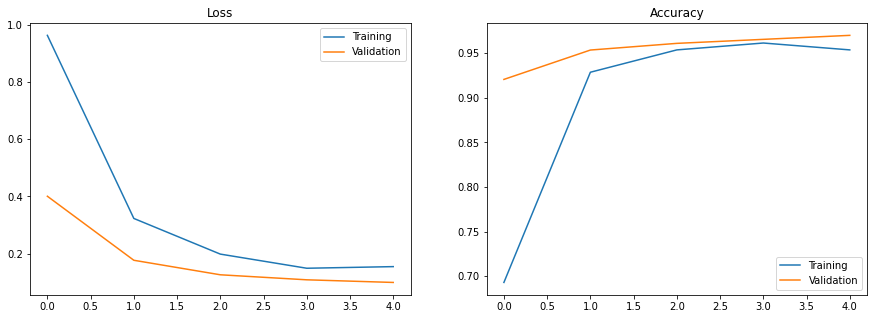

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['sparse_categorical_accuracy'], label='Training')
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [16]:
accuracy_tf = history.history['val_sparse_categorical_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['sparse_categorical_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_sparse_categorical_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_tf, training_time_tf/60))

Accuracy Training data: 95.4%
Accuracy Test data: 97.0%
Training time: 4015.3s (or 66.9 minutes)


The training time is above one hour (on a CPU) and the accuracy looks good (>95%)! We also observe that the accuracy increases with the epochs, and the trianing and validation accuracies are close to each other, meaning there seems to be no overfitting. We will not look further into the entries that produced the wrong prediction, since this is not the goal of this article.

The model has been trained. Now it is time to save the model! If we do not perform this step, all our training effort will be lost...

## Save the model

We can save the model in the format proposed by TensofFlow (extension: h5). We need an additional step, since we are using a custom object (the BERT layer, which comes from the library Hugging Face). See how we can save the model, and load it in a new model. Note that when doing this we lose some properties (like having non-trainable parameters). Be careful when doing this.

In [146]:
model_tf.save('model_tf.h5', save_format='h5')

In [147]:
model_tf2 = models.load_model('model_tf.h5', custom_objects={'TFDistilBertModel': dbert_tf})
model_tf2.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_distil_bert_model_3 (TFD  TFBaseModelOutput(last_h  66362880 
 istilBertModel)             idden_state=(None, 512,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

# Building a Text Classification in PyTorch

## Prepare the Dataset

Let's remember that we have already prepared the dataset (see above, under Dataset). We have also already instantiated a Tokenizer (that is universal across TensorFlow and PyTorch). What we still need to do is customize the dataset to PyTorch. PyTorch has a class for this purpose (classes Dataset and DataLoader). To my knowledge it is mandatory to use Datasets and Dataloaders to train a model. We cannot train a model using NumPy arrays.

In a first step we will convert the dataset into torch tensors, then pack them into a Dataset class, and finally embed the Dataset into a Dataloader.

In [38]:
import torch

X_list=X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 512, truncation=True, return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

Let's split the dataset into training and test data.

In [148]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.3, random_state=42, stratify=y_pt)

We create a Dataset class and will instantiate for both the training and test datasets.

In [149]:
# Convert data to torch dataset
from torch.utils.data import Dataset, DataLoader
class BBCNewsDataset(Dataset):
    """Custom-built BBC News dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y
        

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [150]:
# Get train and test data in form of Dataset class
train_data_pt = BBCNewsDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = BBCNewsDataset(X=X_pt_test, y=y_pt_test)

We embed the datasets into a dataloader, to prepare the dataset to be used for training.

In [151]:
# Get train and test data in form of Dataloader class
train_loader_pt = DataLoader(train_data_pt, batch_size=32)
test_loader_pt = DataLoader(test_data_pt, batch_size=32)

We are now done with the preparation of the dataset! It was a bit more effort than for TensorFlow, but it is worth using the framework PyTorch offers for datasets!

## Build the Model

From now we will follow very closely the approach we have used for TensorFlow and try to stick to the same parameters wherever it is possible.

Let's build the model. For this we first need to get the BERT layer from the transformer library. We configure it such that its parameters will not be trained during training.

Note that we have already defined a config object while building the TensorFlow model. The first line below is therefore not needed. We have added just to allow you to run both models (TensorFlow and PyTorch) independently.

In [152]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_pt = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


You might get a warning message. Don't worry about it. In the context where we apply the model, this message can be ignored.

Let's try to better understand this model by having a closer look at its output. For this, let's take a sample from our training dataset (we take a sample of size five) and look at the output through the model.

In [153]:
# Let's create a sample of size 5 from the training data
sample = X_pt_train[0:5]
print('Object type: ', type(dbert_pt(sample)))
print('Output format (shape): ',dbert_pt(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_pt(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_outputs.BaseModelOutput'>
Output format (shape):  torch.Size([5, 512, 768])
Output used as input for the classifier (shape):  torch.Size([5, 768])


Great news! We get the same format as with TensorFlow. But you can see that this time, the tensor is a torch tensor.

The output is a specific Python object. Among other information, we get a Tensor of size (N, M, S), where N is the size of the dataset (in our case five examples), M is the length of the sample (number of words in the text), and S is the size of the output vector (the output of the model). Typically, as mentioned by Devlin et al. [1], for a classification task, we use the first output vector of a sentence as input for the rest of the classification model, since this first vector "encodes" information about the overall sentence. Alternatively a pooling average of all output vectors could also be used as input for the classifier.

It is now time to build the classification model! It will consist of:

- Distil Bert model: to encode the input data into a new sequence of vectors (that is the output of BERT). Only the first vector of this sequence will be used as an input for the rest of the classifier
- Dropout layer: for regularization
- Dense layer (with relu activation function, with 64 neurons): to solve the specific problem of classification
- Dense layer (with softmax activation function): for a probability distribution for each label

The Dropout layer is used only during training. Some links between the layers are set to zero on purpose, so that its "neighbours" take over its role. This makes the overall prediction more robust. When using the model for inference (prediction), the dropout layers are ignored and the output is re-scaled accordingly. Note that this is one of the reasons why we have to tell the model whether it is in training or in evaluation mode.

In PyTorch we need to define the layers, and then define a forward function that makes use of the layers. Unlike TensorFlow, we do not add an Input Layer. Remember, TensorFlow needed an Input layer to know what will be the size of the various tensors. In the case of PyTorch, each layer gets the Input size and the Output size as confugration parameters, so the information about the dimensions of the tensors is already contained in the model itself. For example, the layer "linear1" gets a vector of size 768 as input, and returns a vector of size 64 as output. These two numbers are part of its definition.

Note as well that in PyTorch we do not define a softmax layer (which would be used to normalize the output, so that the total output sums to 1). Instead the nature of the output (which is a probability and therefore needs to sum to 1) will be included in the definition of the criterion (see below under training).

After creating the model we will look at it via the print function of TensorFlow.

In [154]:
from torch import nn
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert_pt
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        # No need for a softmax, because it is already included in the CrossEntropyLoss
        return logits

model_pt = DistilBertClassification().to(device)

Using cpu device


In [155]:
print(model_pt)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

We still need to define the parameters of the BERT part of the model to "not trainable".

In [156]:
for param in model_pt.dbert.parameters():
    param.requires_grad = False

Let's look at the number of parameters (trainable and non-trainable):

In [157]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412421
Number of trainable parameters:  49541


Awesome! We get the same total number of parameters and number of trainable parameters than for the TensorFlow model. So we are probably not totally wrong! For the reader who skipped the TensorFlow section, we reproduce the analysis on the number of parameters:

Let's quickly check if the number of trainable parameters (which are only in the dense layers, BERT being "frozen") makes sense. The vector that comes out of BERT is one vector of size 768 (by definition of the BERT model). Each of these elements are linked to each of the 64 neurons of the dense layer, leading to 768x64=49'152 parameters. Each neuron has an additional parameter, the bias, i.e. 64 parameters. The output of the dense layer consists of 64 elements, that connect to all the five elements of the classification layer, i.e. 64x5. The classification layer also has 5 bias.

In total, the number of trainable parameters is: 768x64+64+64*5+5 = 49'541! We are there :-)

## Train the Model

It is now time to train the model! Let's do it by keeping in mind that we want to measure the performance (both in terms of accuracy as well as training time), so let's put the measurement in place.

At this stage we will notice a fundamental difference between PyTorch and TensorFlow. While TensorFlow has a "fit" method that allows training within a couple of lines of code, PyTorch requires more effort: we need to define ourselves a training loop, that will loop over epochs (high level) and batches (low level). But by coding the training loops ourselves, this provides us fully transparency on what is being done!

We want to track the progress of the training, similar to what is readily available in TensorFlow. This is why we introduce the dictionary "history", that collects various key performance indicators during the training.

Before we start training we need to configure the number of epochs, the criterion (what is the function to minimize), and the optimizer.

Please go through the code below, which should be self-explanatory.

In [158]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pt.parameters())

In [159]:
from tqdm import tqdm
# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = datetime.now()

# Loop on epochs
for e in range(epochs):
    
    # Set mode in train mode
    model_pt.train()
    
    train_loss = 0.0
    train_accuracy = []
    
    # Loop on batches
    for X, y in tqdm(train_loader_pt):
        
        # Get prediction & loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)
        
        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy
    
    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item()
    
    # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in test_loader_pt:
         
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()
    
    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)    
        
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')
    
# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 49/49 [08:46<00:00, 10.74s/it]


Epoch 1 		 Training Loss:      1.099 		 Validation Loss:      0.537
		 Training Accuracy:    67.373% 		 Validation Accuracy:    90.419%


100%|██████████| 49/49 [08:31<00:00, 10.43s/it]


Epoch 2 		 Training Loss:      0.414 		 Validation Loss:      0.224
		 Training Accuracy:    91.908% 		 Validation Accuracy:    94.910%


100%|██████████| 49/49 [09:38<00:00, 11.81s/it]


Epoch 3 		 Training Loss:      0.220 		 Validation Loss:      0.155
		 Training Accuracy:    95.440% 		 Validation Accuracy:    94.760%


100%|██████████| 49/49 [09:16<00:00, 11.35s/it]


Epoch 4 		 Training Loss:      0.174 		 Validation Loss:      0.130
		 Training Accuracy:    95.633% 		 Validation Accuracy:    95.210%


100%|██████████| 49/49 [09:18<00:00, 11.40s/it]


Epoch 5 		 Training Loss:      0.143 		 Validation Loss:      0.109
		 Training Accuracy:    96.596% 		 Validation Accuracy:    96.407%


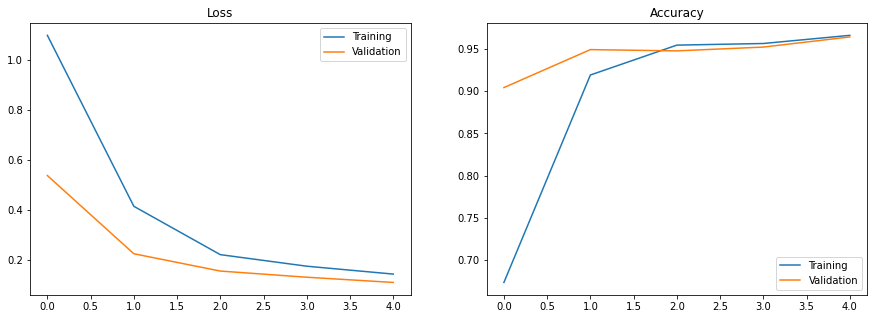

In [160]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [161]:
accuracy_pt = history['valid_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history['valid_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

Accuracy Training data: 96.6%
Accuracy Test data: 96.4%
Training time: 3604.6s (or 60.1 minutes)


The training time lasts one hour (on a CPU), making it faster than TensorFlow. It is to note that we ran the training several times and observed fluctuations in the duration of the order of 10%. The accuracy looks good (>95%)! We also observe that the accuracy increases with the epochs, and the trianing and validation accuracies are close to each other, meaning there seems to be no overfitting. We will not look further into the entries that produced the wrong prediction, since this is not the goal of this article.

Our model is trained! To keep this model, let's save it.

## Save the Model

There are two approaches to save a model and we will cover both in this section.

It is possible to save only the parameters of the model. Then, to load the model, we will first have to instantiate the model (the model DistilBertClassification), then load all its (trained) parameters into this model. This is a convenient way of storing a model, however it is only possible if you have full details about the architecture of the original model.

An alternative is to save the entire model. By doing so it is easier to load the model from its saved location. Let's look at the two approaches.

In [162]:
# Save only the parameters of the model but not the model itself, and get it back
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

In [163]:
# Save the entire model, and get it back
torch.save(model_pt, 'PyModelComplete.pt')
model_reloaded2 = torch.load('PyModelComplete.pt')
model_reloaded2.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

# Comparison TensorFlow vs. PyTorch

We have gone through a classification model using the pre-trained model BERT, and fine-tuning it for the Classificaiton exercise. We have done this in both frameworks TensorFlow and PyTorch. In the present section we highlight the main differences between the two frameworks. A comparison will always contain some subjectivity, therefore please be aware that what follows represent mainly my opinion.

## Programming

When preparing the data, TensorFlow has proven to be very versatile, as it is possible to use NumPy arrays, which is a format in which many datasets are available, and is very easy to manipulate. TensorFlow also has its own tensors (TensorFlow tensors), and its own datasets formats (which we have not covered in this article, you can find details in [ref], chapter [ref]). PyTorch, to the best of our knowledge, requires the use of its own PyTorch tensors, datasets, and dataloaders. This makes the preparation of datasets more rigorous, but this definitely comes at the costs of less flexibility.

For training, TensorFlow offers a high level framework (Keras), which makes training especially easy, using a "fit" function similar to what all Machine Learning engineers know from the scikit learn framework. With TensorFlow it is possible to go to a lower level when training, however not at a level PyTorch offers. In PyTorch, training has to be prepared yourself, at a low level where even the loops over epochs and batches need be defined. The various steps of training (forward, backward, adjustment of parameters) is done in a very granular manner. When training in PyTorch, we get the feeling that "we know what is happening", which is very positive. But unfortunately, there is no high level framework available in PyTorch (as far as we know), which would allow to quickly experiment new models.

## Training & Model

In addition to assessing the difference in programming in both frameworks, let's analyze the training time and the models themselves, especially the accuracy of the models.

In [166]:
framework = ['TensorFlow', 'PyTorch']
accuracy = [accuracy_tf, accuracy_pt]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_tf,1), round(training_time_pt,1)]
training_time_rounded = [str(round(tt,1)) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list((training_time/min(training_time)-1)*100)
training_time_x = [str(round(ttx,1))+'%' for ttx in training_time_x]

dict = {'Framework' : framework,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [% from best]' : training_time_x}
df = pd.DataFrame(dict)
display(df.style.hide_index())

Framework,Accuracy,Training Time [s],Training Time [% from best]
TensorFlow,97.0%,4015.3,11.4%
PyTorch,96.4%,3604.6,0.0%


The training time is for both frameworks at around one hour, slightly faster for PyTorch than for TensorFlow. The accuracy is slightly better for TensorFlow than for PyTorch. Overall, we can consider that both frameworks have a similar performance, in both training time and accuracy. There is no meaningful difference.

# References

[1]: Devlin et al. (2018). “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding” (https://arxiv.org/abs/1810.04805)

[2]: V. Sanh et al (2019), "DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter" (https://arxiv.org/abs/1910.01108)